In [2]:
from pathlib import Path
import prody
import numpy as np
import torch
import dgl

from typing import Iterable, Union, List, Dict

class Unparsable(Exception):
    pass

#processing code adapted from Ian Dunn: https://github.com/Dunni3/keypoint-diffusion/blob/main/data_processing/pdbbind_processing.py

#hard-code in element map for now (find all elements across pockets and hard code it)

In [20]:
#function to parse the receptors
def parse_pocket(pocket_path): #reads in pdb file of a receptor(binding pocket) into a prody AtomGroup
    
    receptor = prody.parsePDB(str(pocket_path))

    if receptor is None: #errors in reading in a pocket
        raise Unparsable
    
    return receptor

#function to return atom positions, features
def get_pocket_atoms(rec_atoms, element_map):

    #position, features and indices for all pocket atoms
    rec_atom_positions = rec_atoms.getCoords()
    rec_atom_features, other_atoms_mask = receptor_featurizer(element_map=element_map, rec_atoms=rec_atoms)

    #convert positions and features to tensors
    rec_atom_positions = torch.tensor(rec_atom_positions).float()
    rec_atom_features = torch.tensor(rec_atom_features).float()

    # remove "other" atoms from the receptor
    rec_atom_positions = rec_atom_positions[~other_atoms_mask]
    rec_atom_features = rec_atom_features[~other_atoms_mask]

    return rec_atom_positions, rec_atom_features


#function to featurize the receptor atoms
def receptor_featurizer(element_map, rec_atoms, protein_atom_elements = None):

    if rec_atoms is None and protein_atom_elements is None:
        raise ValueError
    
    if protein_atom_elements is None:
        protein_atom_elements: np.ndarray = rec_atoms.getElements()

    #one-hot encode atom elements
    onehot_elements = one_hot_encode(protein_atom_elements, element_map)

    #mask "other" atoms
    other_atoms_mask = torch.tensor(onehot_elements[:, -1] == 1).bool()

    #remove "other" category from onehot_elements, assuming they are last in the one-hot encoding
    protein_atom_features = onehot_elements[:, :-1]

    return protein_atom_features, other_atoms_mask


#function to one-hot encode all atoms of the receptor
def one_hot_encode(atom_elements: Iterable, element_map: Dict[str, int]):

    def element_to_idx(element_str, element_map=element_map):
        try:
            return element_map[element_str]
        except KeyError:
            return element_map['other']

    element_idxs = np.fromiter((element_to_idx(element) for element in atom_elements), int)
    onehot_elements = np.zeros((element_idxs.size, len(element_map.values())))
    onehot_elements[np.arange(element_idxs.size), element_idxs] = 1

    return onehot_elements

#function to build a graph from receptor atoms using dgl
def build_pocket_graph(atom_positions: torch.Tensor, atom_features: torch.Tensor, k: int, edge_algorithm: str):
    #add functionality for radius graphs too

    g = dgl.knn_graph(atom_positions, k=k, algorithm=edge_algorithm, dist='euclidean', exclude_self=True)
    g.ndata['x_0'] = atom_positions
    g.ndata['h_0'] = atom_features
    
    return g

In [21]:
#graph class to read in pocket and compute pocket representation

class GraphPocket:
#callable class to read a pocket and output the graph
    
    def __init__(self):

        #hard code element map and k for graph
        self.rec_elements = {'C': 0, 'N': 1, 'O': 2, 'S': 3}
        self.threshold_k = 3
        self.algorithm = 'bruteforce-blas'

    def __call__(self, pocket_path):

        pocket = parse_pocket(pocket_path)
        positions, features = get_pocket_atoms(pocket, self.rec_elements)

        graph = build_pocket_graph(positions, features, self.threshold_k, self.algorithm)

        return graph
        

In [31]:
pocket_to_graph = GraphPocket()

graph = pocket_to_graph(pocket_path='../../TOUGH-M1/data/11asA/11asA_pocket.pdb')

print(graph)

@> 357 atoms and 1 coordinate set(s) were parsed in 0.00s.


Graph(num_nodes=357, num_edges=1071,
      ndata_schemes={'x_0': Scheme(shape=(3,), dtype=torch.float32), 'h_0': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={})
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146,

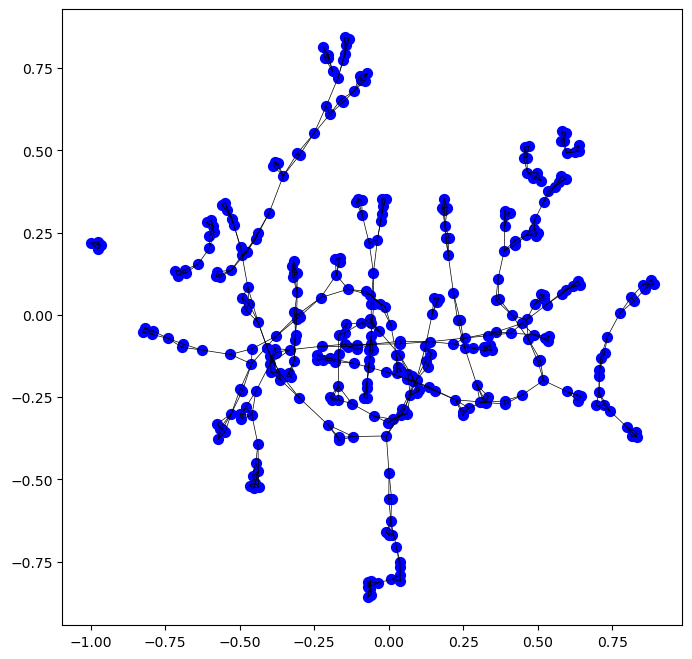

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

nx_g = graph.to_networkx().to_undirected()

# Step 2: Extract Node Features (here, using 'x_0' for coloring)
# Normalize features for coloring or choose a specific feature
node_colors = graph.ndata['x_0'][:, 0].numpy()  # Use the first feature for coloring
node_colors = (node_colors - node_colors.min()) / (node_colors.max() - node_colors.min())

# Step 3: Visualize the Graph
plt.figure(figsize=(8, 8))
# Position nodes using the Spring layout
pos = nx.spring_layout(nx_g, seed=42)
# Draw the nodes (you can map node_colors to any colormap you like)
for edge in nx_g.edges():
    points = np.array([pos[edge[0]], pos[edge[1]]])
    plt.plot(points[:, 0], points[:, 1], 'k-', lw=0.5)

# Draw nodes
for node in nx_g.nodes():
    plt.scatter(pos[node][0], pos[node][1], c='b', s=50)

plt.show()

In [36]:
from Bio.PDB import PDBParser

parser = PDBParser()

structure = parser.get_structure(id = '1lasA', file = '../../TOUGH-M1/data/11asA/11asA_pocket.pdb')

atom_coords = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                atom_coords.append(atom.get_coord())  # Get 3D coordinates of each atom

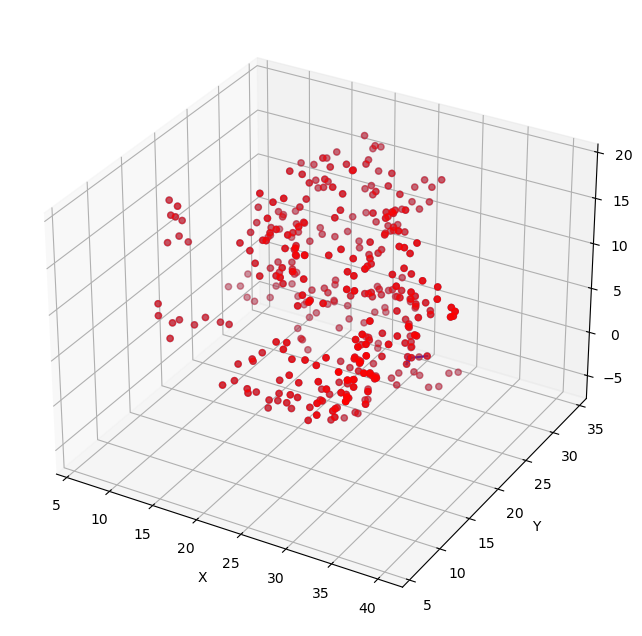

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot atom positions
x, y, z = zip(*atom_coords)
ax.scatter(x, y, z)

ax.scatter(x, y, z, color='r')  # 'r' for nodes, change as needed

# Optionally, draw edges
# For demonstration, let's assume we have a simple edge list
edges = [(0, 1), (1, 2), (2, 3)]  # Example edges, replace with your graph's edges
for edge in edges:
    xs, ys, zs = zip(*[atom_coords[edge[0]], atom_coords[edge[1]]])
    ax.plot(xs, ys, zs, color='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

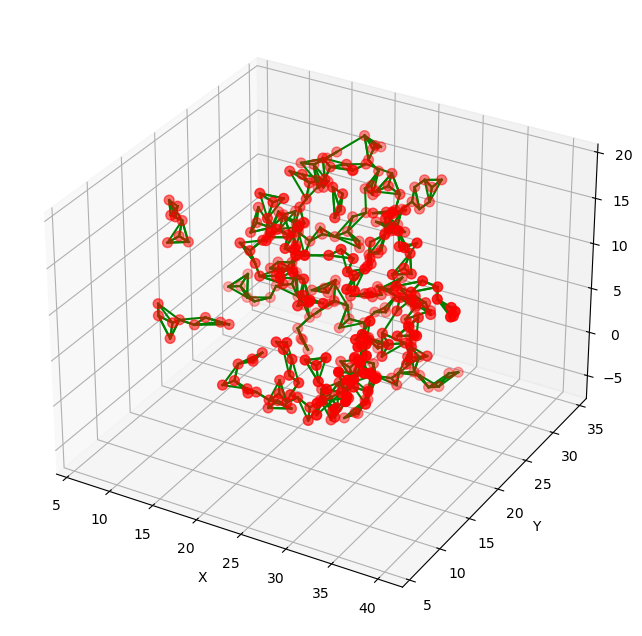

In [40]:
src, dst = graph.edges()

# Convert the tensors to lists for easy handling
src_list = src.tolist()
dst_list = dst.tolist()

# Combine the source and destination lists into a list of tuples representing edges
edge_list = list(zip(src_list, dst_list))

node_coords = np.array(atom_coords)  # Example, replace with actual node positions

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting graph nodes (overlain on the protein structure)
ax.scatter(node_coords[:, 0], node_coords[:, 1], node_coords[:, 2], color='r', s=50)  # Red nodes

# Plotting edges
for edge in edge_list:
    start_pos, end_pos = node_coords[edge[0]], node_coords[edge[1]]
    ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], [start_pos[2], end_pos[2]], color='g')  # Green edges

# You might want to adjust plot limits and other aesthetics
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [41]:
import torch
import dgl 
from dgl.dataloading import GraphDataLoader

import pickle

In [ ]:
##function to read pocket from graph, call the graphpocket class and generate a graph

create_graph = GraphPocket()

def read_pocket(pocket_path):

    return create_graph(pocket_path)

#function for dataloading tuples of the pockets from pocket lists

def dataloader_tuple(pocket_dir, pos_list, neg_list, pock_list, batch_size, num_workers, shuffle=True):

    

    return

In [ ]:
#build a class for a tuple dataset from the positive and negative pairs

class GraphTupleDataset(dgl.data.DGLDataset):

    def __init__(self, pocket_dir, pos_list, neg_list):
        self.pocket_dir = pocket_dir
        self.pos_list = pos_list
        self.neg_list = neg_list

    



In [ ]:
#shift the sequence cluster code here (provided you have the information)